In [77]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import metrics, preprocessing, model_selection
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
pd.options.display.max_columns = 100
import lightgbm as lgb

from scipy import interp

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()

import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("../input/loan-prediction/loan_prediction/loan_prediction/train.csv")
test_df = pd.read_csv("../input/loan-prediction/loan_prediction/loan_prediction/test.csv")
print(train_df.shape, test_df.shape)

(116058, 29) (35866, 28)


In [3]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [36]:
test_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,1,1,3.875,417000,360,1,4,75,1,20,790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,8,4.500,113000,360,1,4,80,2,33,793,2,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,8,4.500,72000,360,0,6,75,1,34,710,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,6,4.125,123000,180,1,4,41,2,24,798,0,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,1,3.250,166000,180,1,4,53,2,12,767,0,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.describe()

,loan_id,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
count,1.160580e+05,116058.000000,1.160580e+05,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
mean,5.494155e+11,3.868961,2.082262e+05,292.280997,67.431939,1.593186,30.742293,769.926778,2.786288,459.611565,0.003257,0.003197,0.002059,0.001973,0.002180,0.003533,0.003421,0.004162,0.004825,0.005359,0.006617,0.007109,0.008065,0.005480
std,2.597560e+11,0.461020,1.146851e+05,89.762415,17.291719,0.491242,9.730798,42.210706,8.096464,381.946926,0.056977,0.063354,0.051391,0.055427,0.062161,0.082638,0.087553,0.100961,0.113128,0.128242,0.148430,0.162884,0.178128,0.073824
min,1.000009e+11,2.250000,1.100000e+04,60.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.244656e+11,3.500000,1.200000e+05,180.000000,57.000000,1.000000,23.000000,751.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.486239e+11,3.875000,1.830000e+05,360.000000,72.000000,2.000000,31.000000,782.000000,0.000000,740.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.743034e+11,4.125000,2.780000e+05,360.000000,80.000000,2.000000,39.000000,800.000000,0.000000,791.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.999971e+11,6.750000,1.200000e+06,360.000000,97.000000,2.000000,64.000000,840.000000,40.000000,836.000000,1.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,1.000000


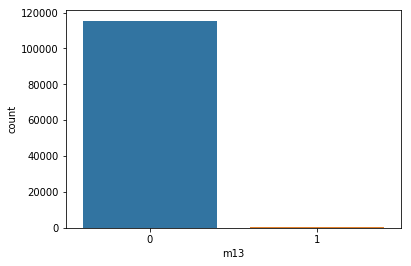

In [5]:
# check target variable is_goal

sns.countplot(train_df['m13'])

Huge imbalanced data

In [7]:
train_y = train_df['m13']

In [ ]:
scale_pos_weight = sqrt(count(negative examples)/count(Positive examples))

In [8]:
# check for NaN values

train_df.isnull().sum()

loan_id                     0
source                      0
financial_institution       0
interest_rate               0
unpaid_principal_bal        0
loan_term                   0
origination_date            0
first_payment_date          0
loan_to_value               0
number_of_borrowers         0
debt_to_income_ratio        0
borrower_credit_score       0
loan_purpose                0
insurance_percent           0
co-borrower_credit_score    0
insurance_type              0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
m13                         0
dtype: int64

In [9]:
# To check what kind of variables are we dealing with - float (continuous) and object(categorial)

pd.options.display.max_rows = 30

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,loan_id,int64
1,source,object
2,financial_institution,object
3,interest_rate,float64
4,unpaid_principal_bal,int64
5,loan_term,int64
6,origination_date,object
7,first_payment_date,object
8,loan_to_value,int64
9,number_of_borrowers,float64


In [10]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,17
1,float64,7
2,object,5


In [11]:
# Check value counts of categorical variables

for i in train_df.columns:
    if train_df[i].dtype=="object":
        print (train_df[i].value_counts())

X    63858
Y    37554
Z    14646
Name: source, dtype: int64
OTHER                          49699
Browning-Hart                  31852
Swanson, Newton and Miller      6874
Edwards-Hoffman                 4857
Martinez, Duffy and Bird        4715
Miller, Mcclure and Allen       3158
Nicholson Group                 2116
Turner, Baldwin and Rhodes      1846
Suarez Inc                      1790
Cole, Brooks and Vincent        1642
Richards-Walters                1459
Taylor, Hunt and Rodriguez      1259
Sanchez-Robinson                1193
Sanchez, Hays and Wilkerson      853
Romero, Woods and Johnson        750
Thornton-Davis                   651
Anderson-Taylor                  483
Richardson Ltd                   473
Chapman-Mcmahon                  388
Name: financial_institution, dtype: int64
2012-02-01    52334
2012-01-01    49093
2012-03-01    14631
Name: origination_date, dtype: int64
04/2012    52840
03/2012    47680
05/2012    15014
02/2012      524
Name: first_payment_date, dtyp

In [12]:
for col in train_df.columns:
    if train_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

source
financial_institution
origination_date
first_payment_date
loan_purpose


In [13]:
train_X = train_df.drop(['loan_id','m13'],axis=1)

In [32]:

test_X = test_df.drop(['loan_id'],axis=1)

In [33]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=200):
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = dep
    params["num_leaves"] = 30
    params["min_data_in_leaf"] = data_leaf
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.35
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed
    params["lambda_l2"] = 5
    params["lambda_l1"] = 5
    params["verbosity"] = -1
     
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    #imps = model.feature_importance()
    #names = model.feature_name()
    #for fi, fn in enumerate(names):
    #    print(fn, imps[fi])

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [78]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 5
skf = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7988)
# gkf = model_selection.GroupKFold(n_splits=n_splits)
model_name = "lgb"
for dev_index, val_index in skf.split(train_X, train_df["m13"].values):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=6, data_leaf=200, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=7, data_leaf=180, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
#     model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=7, data_leaf=200, seed=4568)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1
    
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.856953
Early stopping, best iteration is:
[358]	valid_0's auc: 0.857623
0.8576226445743991
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.854738
0.8547379250595626
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.909784
0.9097844494584377
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[101]	valid_0's auc: 0.911594
0.9115937505862449
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[155]	valid_0's auc: 0.909028
0.90902823921399
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[131]	valid_0's auc: 0.911705
0.9117048724480399
Training until validation scores don't improve for 200 rounds.
Early stoppi

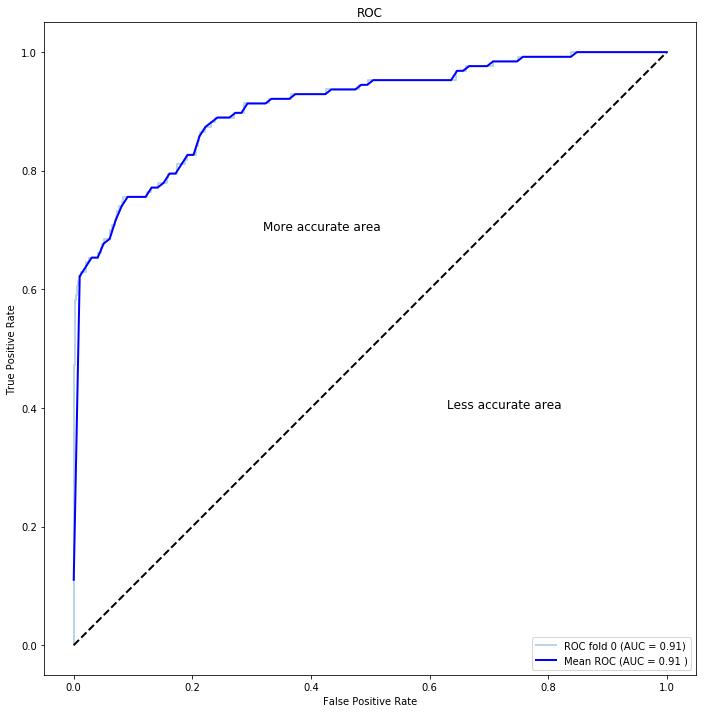

In [79]:
# plot arrows
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

fpr, tpr, t = roc_curve(val_y, pred_val)
tprs.append(interp(mean_fpr, fpr, tpr))
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

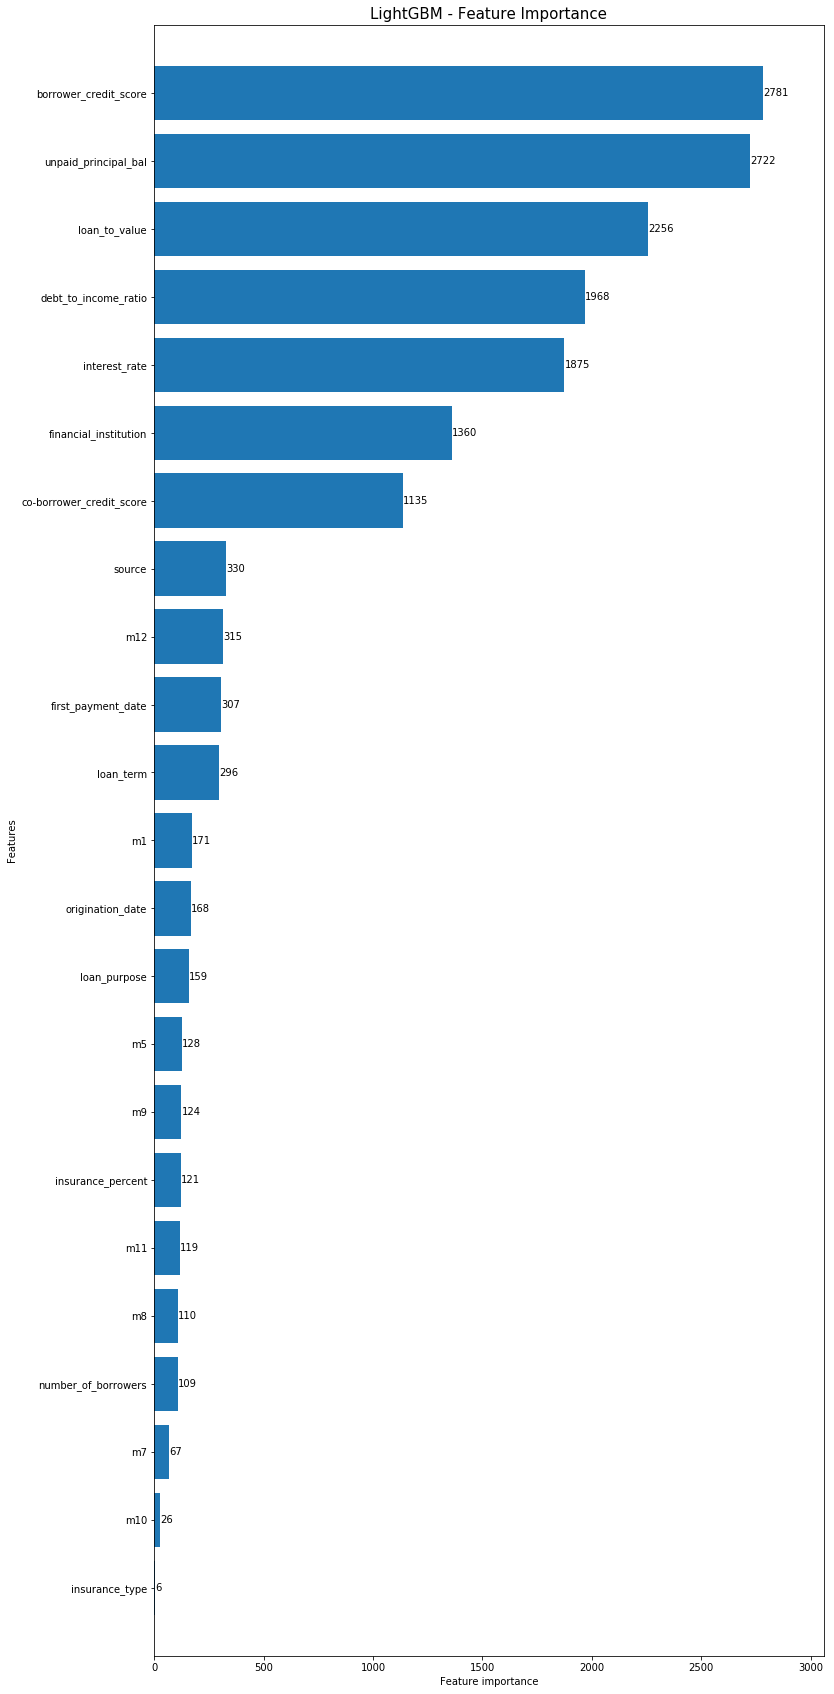

In [81]:
fig, ax = plt.subplots(figsize=(12,30))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [82]:
predictions_lgbm_01 = np.where(pred_test_full > 0.62, 1, 0) #Turn probability to 0-1 binary output

In [83]:
sub_df = pd.DataFrame(test_df[["loan_id"]])
sub_df["m13"] = predictions_lgbm_01
sub_df.to_csv("submission.csv", index=False)